In [1]:
from firecloud import fiss
import pandas as pd
pd.set_option('display.max_row', 10000)
import io
import numpy as np
from pprint import pprint

In [2]:
## start hail context
from hail import *
hc = HailContext(sc)

Running on Apache Spark version 2.0.2
SparkUI available at http://10.128.0.4:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.1-6f85985


In [3]:
samples_sets = fiss.fapi.get_entities('topmed-shared','topmed-shared', 'sample_set').json()
print 'Sample set name:', samples_sets[0]['name']
print 'Sample set fields:', ', '.join(samples_sets[0]['attributes'].keys())


Sample set name: freeze5b_minDP10
Sample set fields: wgsa_subset, gds, vcf, bcf, tbi, cov_grm, samples, wgsa_raw, cor_grm


In [9]:
#https://portal.firecloud.org/#workspaces/topmed-shared/topmed-shared/monitor/121627f8-4a22-475e-9ce3-16214a2607dc/475a4382-ad55-48f4-9e13-ce5436d472a4
# TOPMed JHS subset
vcf_files = ["gs://fc-adaae650-a458-4c56-8a55-d96fa463a5c6/121627f8-4a22-475e-9ce3-16214a2607dc/w/475a4382-ad55-48f4-9e13-ce5436d472a4/call-subset/shard-13/JHS.vcf.bgz",
            "gs://fc-adaae650-a458-4c56-8a55-d96fa463a5c6/121627f8-4a22-475e-9ce3-16214a2607dc/w/475a4382-ad55-48f4-9e13-ce5436d472a4/call-subset/shard-14/JHS.vcf.bgz"]


For analysis, we will want to combine genotype data in several different ways -- and these will be specific to each working group. One of the first operations will be to subset the data to a set of cohorts in the T2D analysis.

In [4]:
data_model = fiss.fapi.get_entities_tsv("topmed-shared","topmed-shared", "sample")
data_model_text = pd.read_csv(io.StringIO(data_model.text), sep='\t')[['entity:sample_id','participant','CENTER','study','topmed_project','consent']]
data_model_text.rename(columns = {'entity:sample_id':'ent_sample_id', 'participant':'sample_id'}, inplace = True)
data_model_text[['study', 'topmed_project','consent']] = data_model_text[['study', 'topmed_project','consent']].astype(str)
data_model_text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56436 entries, 0 to 56435
Data columns (total 6 columns):
ent_sample_id     56436 non-null object
sample_id         56436 non-null object
CENTER            56436 non-null object
study             56436 non-null object
topmed_project    56436 non-null object
consent           56436 non-null object
dtypes: object(6)

Taking a look at the top of this data frame:

In [5]:
data_model_text.head()

,ent_sample_id,sample_id,CENTER,study,topmed_project,consent
0,freeze5a_NWD100014,NWD100014,uw,JHS,JHS,HMB-IRB-NPU
1,freeze5a_NWD100018,NWD100018,broad,COPDGene,COPD,HMB
2,freeze5a_NWD100027,NWD100027,macrogen,GeneSTAR,GeneSTAR,DS-CVD-IRB-NPU-MDS
3,freeze5a_NWD100047,NWD100047,uw,EOCOPD,COPD,DS-CS-RD
4,freeze5a_NWD100048,NWD100048,broad,VU_AF,AFGen,GRU-IRB


We are going to loop through each chromosome, and create vds subsets per cohort/consent group.

In [7]:
i = 1

vcf_file = vcf_files[i]
print vcf_file

label = vcf_file.split('/')[-1]
label = ".".join(label.split('.')[:-2])
print label

gs://fc-adaae650-a458-4c56-8a55-d96fa463a5c6/121627f8-4a22-475e-9ce3-16214a2607dc/w/475a4382-ad55-48f4-9e13-ce5436d472a4/call-subset/shard-13/JHS.vcf.bgz
JHS


In [10]:
vds = hc.import_vcf(vcf_files,min_partitions = 120).split_multi()

2017-11-29 15:46:49 Hail: INFO: No multiallelics detected.
2017-11-29 15:46:49 Hail: INFO: Coerced sorted dataset
2017-11-29 15:46:50 Hail: WARN: called redundant split on an already split VDS


In [30]:
vds.summarize().report()


         Samples: 697
        Variants: 7762483
       Call Rate: 0.991701
         Contigs: ['chr21']
   Multiallelics: 0
            SNPs: 6949524
            MNPs: 0
      Insertions: 287547
       Deletions: 525412
 Complex Alleles: 0
    Star Alleles: 0
     Max Alleles: 2


Annotate the samples

In [11]:
from pyspark.sql import SQLContext
sqlctx = SQLContext(hc.sc)
spark_df = sqlctx.createDataFrame(data_model_text)
kt = KeyTable.from_dataframe(spark_df,key='sample_id') 
vds = vds.annotate_samples_table(kt, root='sa')

Extract samples for each sample/consent combination, excluding the consent="NA"

In [12]:
data_model_text['cohort_consent'] = data_model_text['study'].map(str) + "." + data_model_text['consent']

In [13]:
cohort_consents = data_model_text['cohort_consent'].unique()
print cohort_consents

['JHS.HMB-IRB-NPU' 'COPDGene.HMB' 'GeneSTAR.DS-CVD-IRB-NPU-MDS'
 'EOCOPD.DS-CS-RD' 'VU_AF.GRU-IRB' 'WHI.HMB-IRB' 'CFS.DS-HLBS-IRB-NPU'
 'FHS.HMB-IRB-MDS' 'HyperGEN.GRU-IRB' 'CCAF.GRU-IRB' 'ARIC.HMB-IRB'
 'THRV.DS-CVD-IRB-COL-NPU-RD' 'GENOA.DS-ASC-RF-NPU' 'GenSalt.GRU-IRB'
 'SAFS.nan' 'MESA.HMB' 'BAGS.GRU-IRB' 'GOLDN.DS-CVD-IRB'
 'SAS.GRU-IRB-PUB-COL-NPU-GSO' 'CRA.DS-ASTHMA-IRB-MDS-RD' 'WHI.HMB-IRB-NPU'
 'JHS.HMB-IRB' 'GALAII.DS-LD-RD' 'THRV.nan' 'Mayo.GRU'
 'FHS.HMB-IRB-NPU-MDS' 'COPDGene.DS-CS-RD' 'SAGE.DS-LD'
 'JHS.DS-FDO-IRB-NPU' 'DHS.HMB-IRB-COL-NPU' 'Sarcoidosis.DS-SAR-IRB'
 'JHS.DS-FDO-IRB' 'MESA.nan' 'ARIC.nan' 'MGH_AF.DS-AF-IRB-RD'
 'Amish.HMB-IRB-MDS' 'WGHS.HMB-IRB' 'Partners.HMB' 'MGH_AF.HMB-IRB'
 'nan.nan' 'HyperGEN.DS-CVD-IRB-RD' 'VAFAR.nan' 'VAFAR.HMB-IRB'
 'HVH.HMB-IRB-MDS' 'CHS.HMB-NPU-MDS' 'nan.NRUP' 'BAGS.nan' 'Amish.nan'
 'JHS.nan' 'CFS.nan' 'FHS.nan' 'VU_AF.nan' 'DHS.DS-DHD-IRB-COL-NPU'
 'SAGE.nan' 'GALAII.nan' 'HyperGEN.nan' 'CRA.nan' 'HVH.DS-CVD-IRB-MDS'
 'WGHS.nan

In [14]:
data_model_text['cohort_consent']

0                 JHS.HMB-IRB-NPU
1                    COPDGene.HMB
2     GeneSTAR.DS-CVD-IRB-NPU-MDS
3                 EOCOPD.DS-CS-RD
4                   VU_AF.GRU-IRB
5                   VU_AF.GRU-IRB
6                    COPDGene.HMB
7                     WHI.HMB-IRB
8             CFS.DS-HLBS-IRB-NPU
9                    COPDGene.HMB
10                FHS.HMB-IRB-MDS
11               HyperGEN.GRU-IRB
12    GeneSTAR.DS-CVD-IRB-NPU-MDS
13                   CCAF.GRU-IRB
14                   ARIC.HMB-IRB
...
56421               WHI.HMB-IRB-NPU
56422                  COPDGene.HMB
56423                  COPDGene.HMB
56424                  COPDGene.HMB
56425                   WHI.HMB-IRB
56426                 VU_AF.GRU-IRB
56427                      SAFS.nan
56428    THRV.DS-CVD-IRB-COL-NPU-RD
56429               WHI.HMB-IRB-NPU
56430                  COPDGene.HMB
56431      CRA.DS-ASTHMA-IRB-MDS-RD
56432                 VU_AF.GRU-IRB
56433                  COPDGene.HMB
56434             

In [15]:
cohorts_for_t2d = ['JHS.HMB-IRB-NPU','JHS.HMB-IRB','JHS.DS-FDO-IRB-NPU','JHS.DS-FDO-IRB', 
                   'FHS.HMB-IRB-MDS','FHS.HMB-IRB-NPU-MDS', 'MESA.HMB']
data_model_text['t2d_analysis'] = [1 if x in cohorts_for_t2d else 0 for x in data_model_text['cohort_consent']]

In [16]:
data_model_text.head()

,ent_sample_id,sample_id,CENTER,study,topmed_project,consent,cohort_consent,t2d_analysis
0,freeze5a_NWD100014,NWD100014,uw,JHS,JHS,HMB-IRB-NPU,JHS.HMB-IRB-NPU,1
1,freeze5a_NWD100018,NWD100018,broad,COPDGene,COPD,HMB,COPDGene.HMB,0
2,freeze5a_NWD100027,NWD100027,macrogen,GeneSTAR,GeneSTAR,DS-CVD-IRB-NPU-MDS,GeneSTAR.DS-CVD-IRB-NPU-MDS,0
3,freeze5a_NWD100047,NWD100047,uw,EOCOPD,COPD,DS-CS-RD,EOCOPD.DS-CS-RD,0
4,freeze5a_NWD100048,NWD100048,broad,VU_AF,AFGen,GRU-IRB,VU_AF.GRU-IRB,0


In [17]:
consent_grouped = data_model_text.groupby('t2d_analysis')

In [18]:
one_group = consent_grouped.get_group(1)

In [19]:
one_group["sample_id"].describe()

count         11696
unique        11696
top       NWD542901
freq              1
dtype: object

In [20]:
one_group["sample_id"].values

array(['NWD100014', 'NWD100130', 'NWD100343', ..., 'NWD999511',
       'NWD999550', 'NWD999746'], dtype=object)

In [21]:
vds_subset_one_group = vds.filter_samples_list(list(one_group["sample_id"].values), keep=True)

In [79]:
## this takes a very long time
#vds_subset_one_group.summarize()

Summary(samples=697, variants=7762483, call_rate=0.991701, contigs=['chr21'], multiallelics=0, snps=6949524, mnps=0, insertions=287547, deletions=525412, complex=0, star=0, max_alleles=2)

In [22]:
vds_subset_one_group = vds_subset_one_group.variant_qc().cache()

Filter to variants that have MAC>0 in this sample.

In [24]:
vds_subset_one_group = vds_subset_one_group.filter_variants_expr('va.qc.AC>0').repartition(120)

In [25]:
vds_subset_one_group.summarize().report()


         Samples: 697
        Variants: 998802
       Call Rate: 0.987041
         Contigs: ['chr21']
   Multiallelics: 0
            SNPs: 838512
            MNPs: 0
      Insertions: 69990
       Deletions: 90300
 Complex Alleles: 0
    Star Alleles: 0
     Max Alleles: 2


LD prune - make new data set

In [26]:
vds_result = (vds_subset_one_group.variant_qc()
              .filter_variants_expr("va.qc.AF >= 0.05 && va.qc.AF <= 0.95")
              .ld_prune().repartition(120))

2017-11-29 15:52:18 Hail: INFO: Running LD prune with nSamples=697, nVariants=228050, nPartitions=120, and maxQueueSize=298262.
2017-11-29 15:52:26 Hail: INFO: LD prune step 1 of 3: nVariantsKept=52587, nPartitions=120, time=7.957s
2017-11-29 15:53:21 Hail: INFO: LD prune step 2 of 3: nVariantsKept=50672, nPartitions=3, time=54.929s
2017-11-29 15:53:55 Hail: INFO: Coerced sorted dataset
2017-11-29 15:54:07 Hail: INFO: LD prune step 3 of 3: nVariantsKept=50563, time=46.248s


In [31]:
vds_result.summarize().report()


         Samples: 697
        Variants: 50563
       Call Rate: 0.949005
         Contigs: ['chr21']
   Multiallelics: 0
            SNPs: 35554
            MNPs: 0
      Insertions: 7616
       Deletions: 7393
 Complex Alleles: 0
    Star Alleles: 0
     Max Alleles: 2


In [28]:
#vds_subset_one_group.query_variants('variants.take(5)')

[Variant(contig=chr21, start=36052384, ref=T, alts=[AltAllele(ref=T, alt=TA)]),
 Variant(contig=chr21, start=36052384, ref=TA, alts=[AltAllele(ref=TA, alt=T)]),
 Variant(contig=chr21, start=36052384, ref=TAA, alts=[AltAllele(ref=TAA, alt=T)]),
 Variant(contig=chr21, start=36052384, ref=TAAAAAA, alts=[AltAllele(ref=TAAAAAA, alt=T)]),
 Variant(contig=chr21, start=36052392, ref=A, alts=[AltAllele(ref=A, alt=T)])]

In [29]:
#vds.query_variants('variants.take(5)')

[Variant(contig=chr21, start=14387043, ref=C, alts=[AltAllele(ref=C, alt=A)]),
 Variant(contig=chr21, start=14387043, ref=C, alts=[AltAllele(ref=C, alt=G)]),
 Variant(contig=chr21, start=14387048, ref=A, alts=[AltAllele(ref=A, alt=G)]),
 Variant(contig=chr21, start=14387054, ref=G, alts=[AltAllele(ref=G, alt=T)]),
 Variant(contig=chr21, start=14387059, ref=C, alts=[AltAllele(ref=C, alt=T)])]

In [32]:
#vds_result.query_variants('variants.take(5)')

[Variant(contig=chr21, start=25775603, ref=C, alts=[AltAllele(ref=C, alt=A)]),
 Variant(contig=chr21, start=25777172, ref=C, alts=[AltAllele(ref=C, alt=CT)]),
 Variant(contig=chr21, start=25777191, ref=G, alts=[AltAllele(ref=G, alt=T)]),
 Variant(contig=chr21, start=25779400, ref=G, alts=[AltAllele(ref=G, alt=C)]),
 Variant(contig=chr21, start=25781113, ref=C, alts=[AltAllele(ref=C, alt=CA)])]

## Running PCA on Freeze 5b Genotypes

In [33]:
# do pca
pca = vds_result.pca('sa.pca', k=5, eigenvalues='global.eigen')

2017-11-29 16:00:10 Hail: INFO: Running PCA with 5 components...


In [61]:
pca.summarize()
vds_result.query_samples('samples.map(s => sa.study).counter()')

{u'JHS': 697L}

In [76]:
c = ["aec7e8"] #,"ff7f0e","ffbb78","2ca02c","98df8a","d62728","ff9896","9467bd","c5b0d5","8c564b","c49c94"]
cz = zip(vds_result.query_samples('samples.map(s => sa.study).counter()').keys(),c)
colors = {t[0]: t[1] for t in cz}

pca_table = pca.samples_table().to_pandas()

print colors.items()
print pca_table["sa.study"].map(colors).unique()
pca_table.head()



[(u'JHS', 'aec7e8')]
['aec7e8']


,s,sa.ent_sample_id,sa.CENTER,sa.study,sa.topmed_project,sa.consent,sa.pca.PC1,sa.pca.PC2,sa.pca.PC3,sa.pca.PC4,sa.pca.PC5
0,NWD100014,freeze5a_NWD100014,uw,JHS,JHS,HMB-IRB-NPU,0.005124,0.099248,0.007431,-0.033717,0.061400
1,NWD100597,freeze5a_NWD100597,uw,JHS,JHS,HMB-IRB-NPU,0.084654,-0.015231,-0.041212,-0.010986,0.090482
2,NWD100900,freeze5a_NWD100900,uw,JHS,JHS,HMB-IRB-NPU,0.007049,-0.115969,0.017365,-0.046528,0.080762
3,NWD102903,freeze5a_NWD102903,uw,JHS,JHS,HMB-IRB-NPU,-0.107903,-0.064003,0.040225,-0.111018,0.017785
4,NWD103804,freeze5a_NWD103804,uw,JHS,JHS,HMB-IRB-NPU,-0.108344,0.103910,0.031311,0.013897,0.047623


### Visualize the differences in families within the studies by principle components.

ValueError: to_rgba: Invalid rgba arg "aec7e8"
to_rgb: Invalid rgb arg "aec7e8"
could not convert string to float: aec7e8

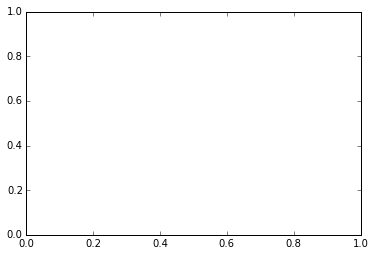

In [75]:

# show the pca results
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter
from math import log, isnan
from pprint import pprint
%matplotlib inline

plt.scatter(pca_table["sa.pca.PC1"], pca_table["sa.pca.PC2"],
            c = pca_table["sa.study"].map(colors),
            alpha = .5)

plt.xlim(-0.6, 0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
legend_entries = [mpatches.Patch(color=c, label=x) for x, c in colors.items()]
plt.show()